# Experiments

## Colab setup

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113


In [2]:
!pip install ogb
!pip install grandiso

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Loading drive:

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Mount the current directory
%cd /content/drive/My\ Drive//CS159_project/Graph_homomorphism/graph_homomorphism

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS159_project/Graph_homomorphism/graph_homomorphism


### imports

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform
from torch_geometric.datasets import TUDataset, ZINC
#import torch_geometric.utils as uts
#from torch_geometric.utils import remove_self_loops, to_undirected

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [21]:
# Graph utilities
import networkx as nx
import graph_encoding.encoding as encoding 


In [32]:
from importlib import reload 

encoding = reload(encoding)



In [27]:
# set up embedding 

def encode(graph, limit_vertex = None,limit_trees = 10000, limit_cycles = 1000, limit_cliques = 100):
    encoded_graph = encoding.grandEmbedding(graph)

    encoded_graph.add_single_vertex(limit_vertex)
    encoded_graph.add_trees(limit_trees)
    encoded_graph.add_cycles(limit_cycles)
    encoded_graph.add_cliques(limit_cliques)

    return encoded_graph
  

## Experiments: graph classification tasks

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold

In [54]:
from torch._C import NoneType
# svm experiment

class SVM_experiment:
  def __init__(self):
      self.clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
      self.cv_scores = None
      self.num_cv = None
  def fit_cv_scores(self, X, y, num_cv = 5, scoring = 'accuracy'):
      self.num_cv = num_cv
      self.cv_scores = cross_val_score(self.clf, X, y, cv=num_cv, scoring= scoring)
  def plot_cv_results(self):
      width = 0.35
      labels = [f'G{n}' for n in range(1,self.num_cv+1)]
      fig = plt.figure()
      ax = fig.add_subplot()
      ax.bar(labels, self.cv_scores, width)
      ax.set_ylabel('Scores')
      ax.set_title('Cross validation scores for SVM')
      plt.axhline(y = self.cv_scores.mean(), c = 'black', linewidth = 0.7, 
            label = f'Err = {self.cv_scores.mean():.2f}' + u"\u00B1" + f'{self.cv_scores.std():.2f}')
      ax.legend()

      plt.show()
      print(f'Error = {self.cv_scores.mean():.2f}' + u"\u00B1" + f'{self.cv_scores.std():.2f}')


### First experiment: MUTAG:

In [25]:
# load the data:

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [34]:
# pre-processing
Encoded_Dataset = [encode(data) for data in tqdm(dataset)]


100%|██████████| 188/188 [00:00<00:00, 2962.15it/s]


In [45]:
# labels
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors
X = np.array([data.ghc_encoder(format = 'numpy')  for data in tqdm(Encoded_Dataset)])
#%timeit Encoded_Dataset[0].ghc_encoder(format = 'numpy') 
#Encoded_Dataset[0].ghc_encoder(format = 'numpy') 
#Encoded_Dataset[0].ghc_encoder(format = 'numpy')

100%|██████████| 188/188 [00:01<00:00, 111.28it/s]


In [49]:
y.shape

(188,)

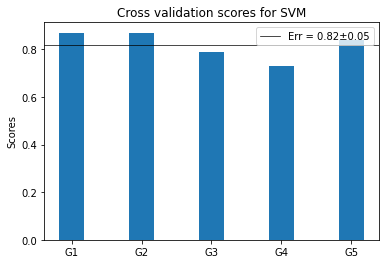

Error = 0.82±0.05


In [55]:
# Run classifier - MUTAG

experiment = SVM_experiment()
experiment.fit_cv_scores(X, y, scoring='f1_weighted')
experiment.plot_cv_results()

### Experiment: IMDB-BIN

In [56]:
# load the data:
dataset = TUDataset(root='data/IMDB-BINARY', name='IMDB-BINARY')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: IMDB-BINARY(1000):
Number of graphs: 1000
Number of features: 0
Number of classes: 2

Data(edge_index=[2, 146], y=[1], num_nodes=20)


In [57]:
# pre-processing
Encoded_Dataset = [encode(data) for data in tqdm(dataset)]

100%|██████████| 1000/1000 [00:00<00:00, 3292.75it/s]


In [62]:
# labels
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors
#X = np.array([data.ghc_encoder(format = 'numpy')  for data in tqdm(Encoded_Dataset)])
#%timeit Encoded_Dataset[0].ghc_encoder(format = 'numpy') 
#Encoded_Dataset[0].ghc_encoder(format = 'numpy') 
%timeit Encoded_Dataset[4].ghc_encoder(format = 'numpy')

1 loop, best of 5: 451 ms per loop


In [ ]:
# Run classifier - IMDB-BIN

experiment = SVM_experiment()
experiment.fit_cv_scores(X, y, scoring='f1_weighted')
experiment.plot_cv_results()